**Notebook from Asan Medical Center**

## Reverse Process (noise -> data)
$$p_\theta(x_{0:T}) = p(x_T)\prod_{t=1}^{T}p_{\theta}(x_{t-1} \vert x_t),\ \ \ \text{where}\ \ \ p_{\theta}(x_{t-1} \vert x_t) = \mathcal{N}(x_{t-1} ; \mu_{\theta}(x_t, t), \Sigma_\theta(x_t, t))$$
<br>
<br>
## Forward Process (data -> noise)
$$ q(x_{1:T} \vert x_0) = \prod_{t=1}^Tq(x_t \vert x_{t-1}),\ \ \ \text{where}\ \ \ q(x_t \vert x_{t-1})=\mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t \mathbf{I})$$

<br>
<br>

Let $\alpha_t = 1-\beta_t$ and $\bar{\alpha_t}=\prod_{s=1}^t\alpha_s$, then $q(x_t \vert x_0)=\mathcal{N}(x_t ; \sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t})\mathbf{I})$

<br>
<br>

$$ \mathbb{E}_q[-\log p_\theta(x_0)] \leq \mathbb{E}_q[-\log {{p_\theta(x_{0:T})}\over{q(x_{1:T} \vert x_0)}}]=\mathbb{E}_q[-\log p(x_T)-\sum_{t\geq1} \log {{ {p_\theta(x_{t-1} \vert x_t)} }\over{q(x_t \vert x_{t-1})}} ]=L $$

<br>
<br>

Rewrite $L$:
$$\begin{align}L &= \mathbb{E}_q [ D_{KL}(q(x_T|x_0) || p(x_T)) + \sum_{t>1}D_{KL}(q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t))-\log p_\theta (x_0|x_1) ] \end{align}$$
where, $q(x_{t-1} \vert x_t, x_0)=\mathcal{N}(x_{t-1};\tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t)$ with $\tilde{\mu}_t(x_t, x_0)=\frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1}) }{1-\bar{\alpha}_t}x_t$ and $\tilde{\beta}_t=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t$

<br>
<br>

We fixed $\beta_t$ in Forward Process. And $ \Sigma_\theta(x_t,t)=\sigma_t^2$ set $\beta_t$ or ${{ 1-\bar{\alpha}_{t-1} }\over{1-\bar{\alpha}_{t}}}\beta_t$ and the $\mu_{\theta}$ is:
$$\mu_{\theta}(x_t, t) \approx \tilde{\mu}_t(x_t, x_0) =\frac{1}{\sqrt{\alpha_t}}(x_t(x_0, \epsilon) - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon)$$

<br>
<br>

Let $\epsilon_{\theta}$ be a approximator, which predicts a $\epsilon$ from $x_t$. Then, the $\mu_{\theta}$ is:
$$\mu_{\theta}(x_t, t) =\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_{\theta}(x_t, t))$$

<br>
<br>

Therefore, to sample $x_{t-1} \sim p_{\theta}(x_{t-1} \vert x_t)$ is to compute $x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(x_t, t)) + \sigma_tz $

<br>
<br>

Finally, since $x_t \sim q(x_t \vert x_0)=\mathcal{N}(x_t ; \sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t})\mathbf{I})$, the training objective function is:

$$\mathcal{L}_{simple}(\theta)=\mathbb{E}_{t, x_0, \epsilon}[\Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon\Vert^2]$$

### **Model**
<img src="https://drive.google.com/uc?export=download&id=1KthYkyCbwolqt5drnGMS8AbYn8U5zU5V" align="center" style="float" width="700">

In [1]:
TRAIN = True

In [2]:
if not TRAIN:
  import pickle
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1Rj5zqrbqYSc7EiV2F_8UK39w94uLZ_mi',
                                      dest_path='./ddpm_model_toy1.pkl')
  gdd.download_file_from_google_drive(file_id='1MtS6h02IaEDguoBnu8Jjq0BOEvkt8AAn',
                                      dest_path='./ddpm_model_toy2.pkl')

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import init
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial

<ipython-input-3-0d5342f649dc>:9: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [4]:
class Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 2):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 256)

        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(0.2),
            nn.GELU(),

            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.GELU(),

            nn.Linear(512, input_dim),
        )
    def forward(self, x, idx):
        x = self.linear_model2(self.linear_model1(x) + self.embedding_layer(idx))
        return x


In [5]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = Backbone(T, input_dim)

        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss


    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon

        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x



        output = self.backbone(x_tilde, idx)

        return (output, epsilon, used_alpha_bars) if get_target else output


In [6]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape

        self.diffusion_fn = diffusion_fn
        self.device = device


    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step
        '''
        sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []

        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [7]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]

        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [32]:
def scatter(sample, only_final, scatter_range = [-10, 10]):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(7, 7))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=5)
        plt.show()

    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=5)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        plt.show()

# Example 1

$$p_{data} = \frac{1}{5} \times \mathcal{N}((3,3), I) + \frac{4}{5} \times \mathcal{N}((-3,-3), I)$$

In [8]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2, shape = (2), probability=0.2, total_len = 1000000):
        self.dist1_mean, self.dist1_var = dist1[0], dist1[1]
        self.dist2_mean, self.dist2_var = dist2[0], dist2[1]
        self.shape = shape
        self.probability = probability
        self.total_len = total_len

    @property
    def get_probability(self):
        return torch.rand(1) < self.probability

    @property
    def _sampling_1(self):
        return self.dist1_mean + torch.randn(self.shape) * self.dist1_var

    @property
    def _sampling_2(self):
        return self.dist2_mean + torch.randn(self.shape) * self.dist2_var

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        data = self._sampling_1 if self.get_probability else self._sampling_2

        return data

## Hyperparameters of model and perturbation process


In [10]:
# betas: linear decaying
beta_1 = 1e-4
beta_T = 0.02

T = 100
shape = (2,)
device = torch.device('cuda')

In [11]:
if TRAIN:
  model = Model(device, beta_1, beta_T, T, shape[0])
else:
  with open("ddpm_model_toy1.pkl", "rb") as f:
    model = pickle.load(f)

optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape=shape)

## Hyperparameters of Training

In [12]:
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

In [13]:
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size = 8192 * 2
dataloader = torch.utils.data.DataLoader(DataSet(dist1, dist2, probability=probability,
                                                 total_len=batch_size * total_iteration
                                                 ),
                                         batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

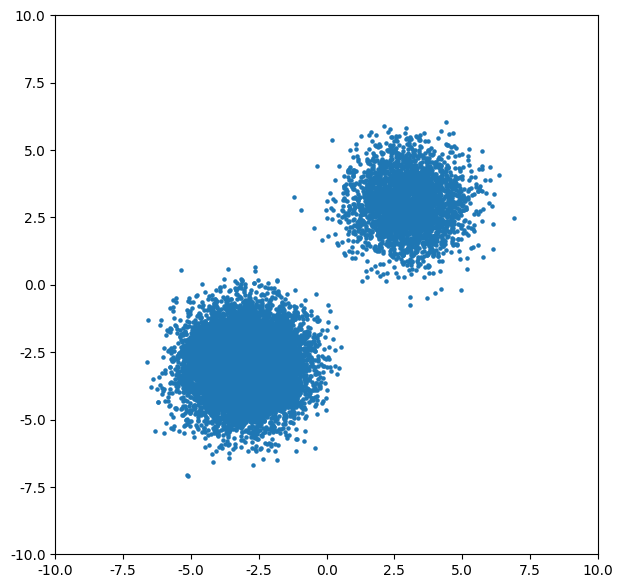

In [14]:
scatter(next(iter(dataloader)), True)

## Training Phase

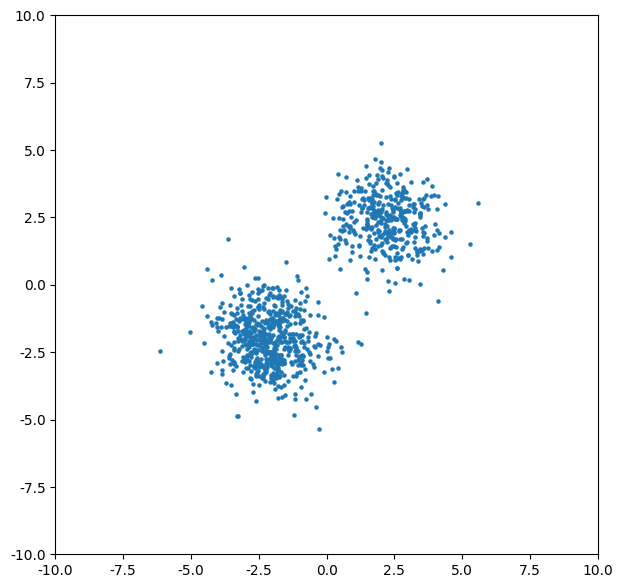

Iteration [ 809/1000]	Loss 0.7476 (0.7541)

Exception ignored in: <function _xla_gc_callback at 0x7e4cc4f1c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Iteration [ 817/1000]	Loss 0.7510 (0.7545)

In [ ]:
if TRAIN:
  while current_iteration != total_iteration:
      try:
          data = next(dataiterator)
      except:
          dataiterator = iter(dataloader)
          data = next(dataiterator)
      data = data.to(device = device)
      loss = model.loss_fn(data)

      optim.zero_grad()
      loss.backward()
      optim.step()

      losses.update(loss.item())
      progress.display(current_iteration)
      current_iteration += 1

      if current_iteration % display_iteration == 0:
          process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
          sample = process.sampling(sampling_number, only_final)
          scatter(sample, sampling_number)
          losses.reset()

## Inference Phase (Sampling)

In [ ]:
sampling_number = 1000
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)
scatter(sample, only_final)

In [ ]:
sampling_number = 1000
only_final = False
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)
scatter(sample[9::10], only_final)

In [ ]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=50)
writergif = animation.PillowWriter(fps=40)

ani.save('ddpm_toy1.gif', writer=writergif)
HTML(ani.to_jshtml())

# Example 2 : swiss roll

In [ ]:
from sklearn.datasets import make_swiss_roll

In [ ]:
class DataSet2(torch.utils.data.Dataset):
    def __init__(self, total_len = 1000000):

        self.total_len = total_len
        self.data = make_swiss_roll(n_samples = total_len)[0][:,[0,2]]
        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())
        self.data = self.data * 10 - 5

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        data = self.data[idx]

        return data

## Hyperparameter of model and diffusion process


In [ ]:
device = torch.device('cuda')

beta_1 = 1e-4
beta_T = 0.02
T = 100
shape = (2,)

In [ ]:
if TRAIN:
  model = Model(device, beta_1, beta_T, T, input_dim = shape[0])
else:
  with open("ddpm_model_toy2.pkl", "rb") as f:
    model = pickle.load(f)

optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = DiffusionProcess(beta_1, beta_T, T, model, device, shape=shape)

## Hyperparameter of Training

In [ ]:
only_final = True
batch_size = 8192 * 2
dataloader = torch.utils.data.DataLoader(DataSet2(batch_size), batch_size = batch_size, drop_last = True, shuffle = True)
dataiterator = iter(dataloader)

In [ ]:
scatter(next(iter(dataloader)), True)

In [ ]:
scatter_range = [-7, 7]
total_iteration = 2000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

## Training Phase

In [ ]:
if TRAIN:
  while current_iteration != total_iteration:
      try:
          data = next(dataiterator)
      except:
          dataiterator = iter(dataloader)
          data = next(dataiterator)
      data = data.to(device = device).float()
      loss = model.loss_fn(data)

      optim.zero_grad()
      loss.backward()
      optim.step()

      losses.update(loss.item())
      progress.display(current_iteration)
      current_iteration += 1

      if current_iteration % display_iteration == 0:
          process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
          sample = process.sampling(sampling_number, only_final)
          scatter(sample, only_final, scatter_range = scatter_range)
          losses.reset()
else:
  with open("ddpm_model_toy2.pkl", "rb") as f:
    model = pickle.load(f)

## Inference Phase (Sampling)

In [ ]:
sampling_number = 10000
only_final = False
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)


In [ ]:
scatter(sample[9::10], only_final)

In [ ]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
writergif = animation.PillowWriter(fps=50)

ani.save('ddpm_toy2.gif', writer=writergif)
HTML(ani.to_jshtml())

# Example 3

In [25]:
class DataSet2(torch.utils.data.Dataset):
    def __init__(self, total_len = 1000000):

        self.total_len = total_len

        # Aqui cambio los datos

        #self.data = make_swiss_roll(n_samples = total_len)[0][:,[0,2]]
        x = np.random.randn((total_len))
        y = np.cos(x)
        self.data = np.zeros((total_len,2))
        self.data[:,0] = x
        self.data[:,1] = y

        self.data[self.data[:,0]>0,1] = -self.data[self.data[:,0]>0,1]

        self.data = self.data + 0.01*np.random.randn(total_len,2)

        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())
        self.data = self.data * 10 - 5

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        data = self.data[idx]

        return data

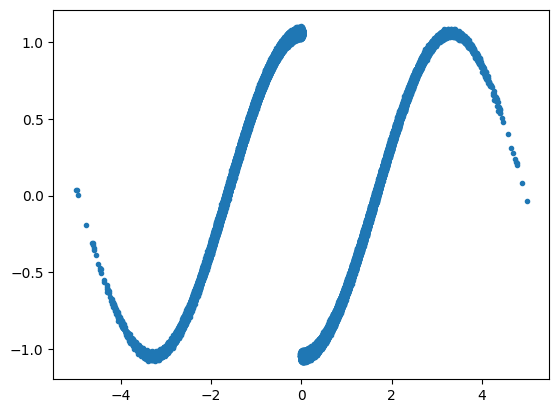

In [26]:
data = DataSet2()

plt.plot(data[:,0],data[:,1],'.')

## Hyperparameter of model and diffusion process


In [27]:
device = torch.device('cuda')

beta_1 = 1e-4
beta_T = 0.02
T = 100
shape = (2,)

In [28]:
if TRAIN:
  model = Model(device, beta_1, beta_T, T, input_dim = shape[0])
else:
  with open("ddpm_model_toy2.pkl", "rb") as f:
    model = pickle.load(f)

optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = DiffusionProcess(beta_1, beta_T, T, model, device, shape=shape)

## Hyperparameter of Training

In [29]:
only_final = True
batch_size = 8192 * 2
dataloader = torch.utils.data.DataLoader(DataSet2(batch_size), batch_size = batch_size, drop_last = True, shuffle = True)
dataiterator = iter(dataloader)

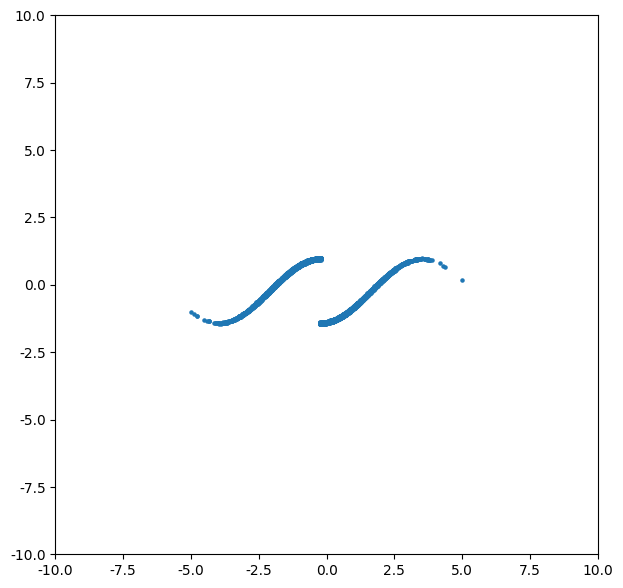

In [33]:
scatter(next(iter(dataloader)), True)

In [35]:
scatter_range = [-7, 7]
total_iteration = 1000
current_iteration = 0
display_iteration = 100
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

## Training Phase

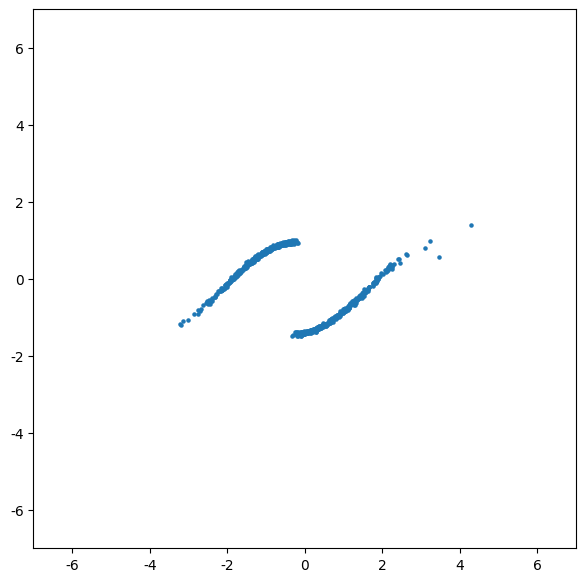

In [36]:
if TRAIN:
  while current_iteration != total_iteration:
      try:
          data = next(dataiterator)
      except:
          dataiterator = iter(dataloader)
          data = next(dataiterator)
      data = data.to(device = device).float()
      loss = model.loss_fn(data)

      optim.zero_grad()
      loss.backward()
      optim.step()

      losses.update(loss.item())
      progress.display(current_iteration)
      current_iteration += 1

      if current_iteration % display_iteration == 0:
          process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
          sample = process.sampling(sampling_number, only_final)
          scatter(sample, only_final, scatter_range = scatter_range)
          losses.reset()
else:
  with open("ddpm_model_toy2.pkl", "rb") as f:
    model = pickle.load(f)

## Inference Phase (Sampling)

In [38]:
sampling_number = 10000
only_final = False
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)


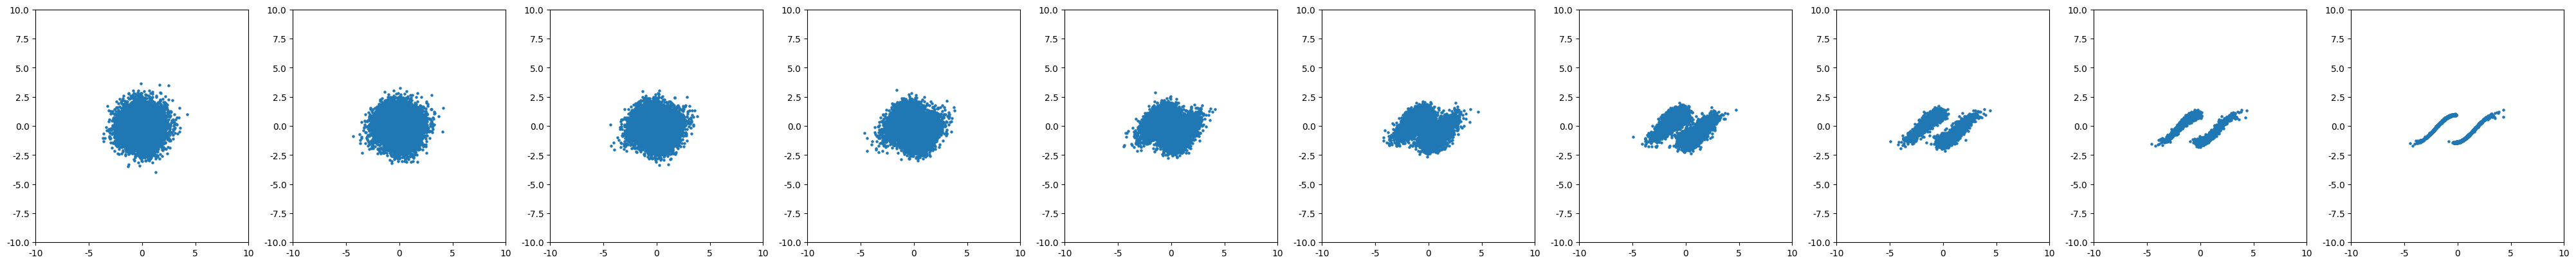

In [39]:
scatter(sample[9::10], only_final)

In [40]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
writergif = animation.PillowWriter(fps=50)

ani.save('ddpm_toy2.gif', writer=writergif)
HTML(ani.to_jshtml())